# Import library

In [9]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from torch import tensor, Tensor
import torchvision
from tqdm import tqdm
import os
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score

# Functions

In [21]:
def prepare_data():
    # Define the transform function
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    # Load the train MNIST dataset
    train_mnist_dataset = torchvision.datasets.MNIST(root="./", train=True, transform=transform,
                                                     download=True)
    n_train_samples = len(train_mnist_dataset)
    # Load the test MNIST dataset
    test_mnist_dataset = torchvision.datasets.MNIST(root="./", train=False, transform=transform,
                                                    download=True)

    if not os.path.exists("transformed_dataset.pt"):
        random_pairs = np.random.randint(n_train_samples, size=[n_train_samples, 2])
        random_pairs = [(row[0], row[1]) for row in random_pairs]

        # Transform the data
        transformed_dataset = [
            create_negative_image(train_mnist_dataset[pair[0]][0].squeeze(), train_mnist_dataset[pair[1]][0].squeeze())
            for pair in tqdm(random_pairs)]

        # Save the transformed images to a folder
        torch.save(transformed_dataset, 'transformed_dataset.pt')

In [3]:
def create_mask(shape, iterations: int = 10):
    """
    Create a binary mask as described in (Hinton, 2022): start with a random binary image and then repeatedly blur
    the image with a filter, horizontally and vertically.

    Parameters
    ----------
    shape : tuple
        The shape of the output mask (height, width).
    iterations : int
        The number of times to blur the image.

    Returns
    -------
    numpy.ndarray
        A binary mask with the specified shape, containing fairly large regions of ones and zeros.
    """

    blur_filter_1 = np.array(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)))
    blur_filter_2 = blur_filter_1.T

    # Create a random binary image
    image = np.random.randint(0, 2, size=shape)

    # Blur the image with the specified filter
    for i in range(iterations):
        image = np.abs(convolve2d(image, blur_filter_1, mode='same') / blur_filter_1.sum())
        image = np.abs(convolve2d(image, blur_filter_2, mode='same') / blur_filter_2.sum())

    # Binarize the blurred image, i.e. threshold it at 0.5
    mask = np.round(image).astype(np.uint8)

    return tensor(mask)

In [4]:
def create_negative_image(image_1: Tensor, image_2: Tensor):
    """
    Create a negative image by combining two images with a binary mask.

    Parameters:
    image_1 (Tensor): The first image to be combined.
    image_2 (Tensor): The second image to be combined.

    Returns:
    Tensor: The negative image created by combining the two input images.

    Raises:
    AssertionError: If the shapes of `image_1` and `image_2` are not the same.

    Examples:
    >>> image_1 = np.random.randint(0, 2, size=(5, 5))
    >>> image_2 = np.random.randint(0, 2, size=(5, 5))
    >>> create_negative_image(image_1, image_2)
    array([[0 0 0 0 1]
           [1 1 0 1 1]
           [0 0 0 1 1]
           [0 1 1 1 0]
           [1 1 0 0 1]])
    """

    assert image_1.shape == image_2.shape, "Incompatible images and mask shapes."

    mask = create_mask((image_1.shape[0], image_1.shape[1]))

    image_1 = torch.mul(image_1, mask)
    image_2 = torch.mul(image_2, 1 - mask)

    return torch.add(image_1, image_2)

In [5]:
def create_negative_batch(images: Tensor):
    neg_imgs = []
    batch_size = images.shape[0]
    for _ in range(batch_size):
        idx1, idx2 = np.random.randint(batch_size, size=2)
        neg_imgs.append(create_negative_image(images[idx1].squeeze(), images[idx2].squeeze()))
    return torch.unsqueeze(torch.stack(neg_imgs), dim=1)

In [10]:
def goodness_score(pos_acts, neg_acts, threshold=2):
    """
    Compute the goodness score for a given set of positive and negative activations.

    Parameters:

    pos_acts (torch.Tensor): Numpy array of positive activations.
    neg_acts (torch.Tensor): Numpy array of negative activations.
    threshold (int, optional): Threshold value used to compute the score. Default is 2.

    Returns:

    goodness (torch.Tensor): Goodness score computed as the sum of positive and negative goodness values. Note that this
    score is actually the quantity that is optimized and not the goodness itself. The goodness itself is the same
    quantity but without the threshold subtraction
    """

    pos_goodness = -torch.sum(torch.pow(pos_acts, 2)) + threshold
    neg_goodness = torch.sum(torch.pow(neg_acts, 2)) - threshold
    return torch.add(pos_goodness, neg_goodness)

In [11]:
def get_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    return dict(accuracy_score=acc)

In [12]:
class FF_Layer(nn.Linear):
    def __init__(self, in_features: int, out_features: int, n_epochs: int, bias: bool, device):
        super().__init__(in_features, out_features, bias=bias)
        self.n_epochs = n_epochs
        self.opt = torch.optim.Adam(self.parameters())
        self.goodness = goodness_score
        self.to(device)
        self.ln_layer = nn.LayerNorm(normalized_shape=[1, out_features]).to(device)

    def ff_train(self, pos_acts, neg_acts):
        """
        Train the layer using positive and negative activations.

        Parameters:

        pos_acts (numpy.ndarray): Numpy array of positive activations.
        neg_acts (numpy.ndarray): Numpy array of negative activations.
        """

        self.opt.zero_grad()
        goodness = self.goodness(pos_acts, neg_acts)
        goodness.backward()
        self.opt.step()

    def forward(self, input):
        input = super().forward(input)
        input = self.ln_layer(input.detach())
        return input


In [13]:
class Unsupervised_FF(nn.Module):
    def __init__(self, n_layers: int = 4, n_neurons=2000, input_size: int = 28 * 28, n_epochs: int = 100,
                 bias: bool = True, n_classes: int = 10, n_hid_to_log: int = 3, device=torch.device("cuda:0")):
        super().__init__()
        self.n_hid_to_log = n_hid_to_log
        self.n_epochs = n_epochs
        self.device = device

        ff_layers = [
            FF_Layer(in_features=input_size if idx == 0 else n_neurons,
                     out_features=n_neurons,
                     n_epochs=n_epochs,
                     bias=bias,
                     device=device) for idx in range(n_layers)]

        self.ff_layers = ff_layers
        self.last_layer = nn.Linear(in_features=n_neurons * n_hid_to_log, out_features=n_classes, bias=bias)
        self.to(device)
        self.opt = torch.optim.Adam(self.last_layer.parameters())
        self.loss = torch.nn.CrossEntropyLoss(reduction="mean")

    def train_ff_layers(self, pos_dataloader, neg_dataloader):
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training FF Layers", position=0)
        for epoch in outer_tqdm:
            inner_tqdm = tqdm(zip(pos_dataloader, neg_dataloader), desc=f"Training FF Layers | Epoch {epoch}",
                              leave=False, position=1)
            for pos_data, neg_imgs in inner_tqdm:
                pos_imgs, _ = pos_data
                pos_acts = torch.reshape(pos_imgs, (pos_imgs.shape[0], 1, -1)).to(self.device)
                neg_acts = torch.reshape(neg_imgs, (neg_imgs.shape[0], 1, -1)).to(self.device)

                for idx, layer in enumerate(self.ff_layers):
                    pos_acts = layer(pos_acts)
                    neg_acts = layer(neg_acts)
                    layer.ff_train(pos_acts, neg_acts)

    def train_last_layer(self, dataloader: DataLoader):
        num_examples = len(dataloader)
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training Last Layer", position=0)
        loss_list = []
        for epoch in outer_tqdm:
            epoch_loss = 0
            inner_tqdm = tqdm(dataloader, desc=f"Training Last Layer | Epoch {epoch}", leave=False, position=1)
            for images, labels in inner_tqdm:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.opt.zero_grad()
                preds = self(images)
                loss = self.loss(preds, labels)
                epoch_loss += loss
                loss.backward()
                self.opt.step()
            loss_list.append(epoch_loss / num_examples)
            # Update progress bar with current loss
        return [l.detach().cpu().numpy() for l in loss_list]

    def forward(self, image: torch.Tensor):
        image = image.to(self.device)
        image = torch.reshape(image, (image.shape[0], 1, -1))
        concat_output = []
        for idx, layer in enumerate(self.ff_layers):
            image = layer(image)
            if idx > len(self.ff_layers) - self.n_hid_to_log - 1:
                concat_output.append(image)
        concat_output = torch.concat(concat_output, 2)
        logits = self.last_layer(concat_output)
        return logits.squeeze()

    def evaluate(self, dataloader: DataLoader, dataset_type: str = "train"):
        self.eval()
        inner_tqdm = tqdm(dataloader, desc=f"Evaluating model", leave=False, position=1)
        all_labels = []
        all_preds = []
        for images, labels in inner_tqdm:
            images = images.to(self.device)
            labels = labels.to(self.device)
            preds = self(images)
            preds = torch.argmax(preds, 1)
            all_labels.append(labels.detach().cpu())
            all_preds.append(preds.detach().cpu())
        all_labels = torch.concat(all_labels, 0).numpy()
        all_preds = torch.concat(all_preds, 0).numpy()
        metrics_dict = get_metrics(all_preds, all_labels)
        print(f"{dataset_type} dataset scores: ", "\n".join([f"{key}: {value}" for key, value in metrics_dict.items()]))



In [14]:
def train(model: Unsupervised_FF, pos_dataloader: DataLoader, neg_dataloader: DataLoader):
    model.train()
    model.train_ff_layers(pos_dataloader, neg_dataloader)
    return model.train_last_layer(pos_dataloader)


In [32]:
def plot_loss(loss):
    # plot the loss over epochs
    fig = plt.figure()
    plt.plot(list(range(len(loss))),loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.savefig("Loss Plot.png")
    plt.show()

# load mnist and run

In [36]:
mnist = torchvision.datasets.MNIST(root='data/', download=True)

# Get the first instance of the digit 1
image_1, _ = mnist[np.random.randint(len(mnist))]
image_2, _ = mnist[np.random.randint(len(mnist))]

image_1 = torch.as_tensor(np.asarray(image_1))
image_2 = torch.as_tensor(np.asarray(image_2))

mask = create_mask((28, 28))
image = create_negative_image(image_1, image_2)


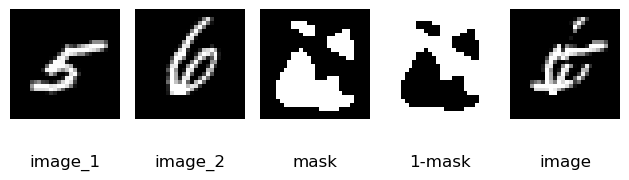

In [37]:
# Create the subplot
fig, ax = plt.subplots(1, 5)
images = [image_1, image_2, mask, 1 - mask, image]
names = ["image_1", "image_2", "mask", "1-mask", "image"]
# Add the images to the subplot
for i, image in enumerate(images):
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(names[i], y=-0.5)

# Show the subplot
plt.tight_layout()
plt.show()

In [22]:
prepare_data()

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 3410036.83it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 3060295.93it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2683986.10it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:33<00:00, 1790.98it/s]


In [23]:
    # Load the MNIST dataset
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
    # pos_dataset = Subset(pos_dataset, list(range(1000)))
    # Create the data loader
    pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)

In [24]:
    # Load the transformed images
    neg_dataset = torch.load('transformed_dataset.pt')
    # Create the data loader
    neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

In [25]:
    # Load the test images
    test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
    # Create the data loader
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

In [26]:
device = torch.device("cuda:0")
unsupervised_ff = Unsupervised_FF(device=device, n_epochs=2)

In [27]:
loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

Training FF Layers:   0%|                                                                        | 0/2 [00:00<?, ?it/s]
Training FF Layers | Epoch 0: 0it [00:00, ?it/s]
Training FF Layers | Epoch 0: 1it [00:00,  2.20it/s]
Training FF Layers | Epoch 0: 10it [00:00, 22.66it/s]
Training FF Layers | Epoch 0: 19it [00:00, 38.92it/s]
Training FF Layers | Epoch 0: 42it [00:00, 86.45it/s]
Training FF Layers | Epoch 0: 64it [00:00, 121.27it/s]
Training FF Layers | Epoch 0: 86it [00:00, 146.75it/s]
Training FF Layers | Epoch 0: 110it [00:01, 169.06it/s]
Training FF Layers | Epoch 0: 132it [00:01, 183.36it/s]
Training FF Layers | Epoch 0: 155it [00:01, 196.62it/s]
Training FF Layers | Epoch 0: 178it [00:01, 204.45it/s]
Training FF Layers | Epoch 0: 203it [00:01, 214.04it/s]
Training FF Layers | Epoch 0: 227it [00:01, 220.38it/s]
Training FF Layers | Epoch 0: 253it [00:01, 227.26it/s]
Training FF Layers | Epoch 0: 277it [00:01, 230.93it/s]
Training FF Layers | Epoch 0: 301it [00:01, 223.00it/s]
Tr

Training Last Layer | Epoch 0:  84%|████████████████████████████████████████▍       | 789/938 [00:03<00:00, 442.76it/s]
Training Last Layer | Epoch 0:  90%|███████████████████████████████████████████     | 841/938 [00:03<00:00, 452.30it/s]
Training Last Layer | Epoch 0:  95%|█████████████████████████████████████████████▋  | 894/938 [00:03<00:00, 461.58it/s]
Training Last Layer:  50%|███████████████████████████████▌                               | 1/2 [00:04<00:04,  4.44s/it]
Training Last Layer | Epoch 1:   0%|                                                           | 0/938 [00:00<?, ?it/s]
Training Last Layer | Epoch 1:   0%|                                                   | 1/938 [00:01<25:22,  1.63s/it]
Training Last Layer | Epoch 1:   1%|▌                                                 | 11/938 [00:01<01:48,  8.58it/s]
Training Last Layer | Epoch 1:   4%|██▏                                               | 40/938 [00:01<00:24, 37.11it/s]
Training Last Layer | Epoch 1:   7%|███▌

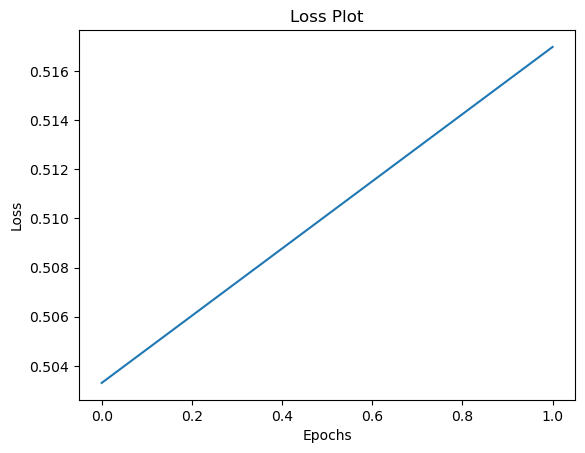

In [33]:
plot_loss(loss)

In [29]:
unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")


Evaluating model:  94%|█████████████████████████████████████████████████████████▎   | 881/938 [00:03<00:00, 643.65it/s]
                                                                                                                       

Train dataset scores:  accuracy_score: 0.9043



Evaluating model:  87%|████████████████████████████████████████████████████▊        | 136/157 [00:01<00:00, 139.38it/s]
                                                                                                                       

Test dataset scores:  accuracy_score: 0.9007
